# Fashion MNIST using PyTorch

## 1. Importing libraries

In [140]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer 


# Custom
import mllib.DNN_utils as DNN_utils

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Getting dataset

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="../", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="../",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

### 2.1 Taking a peek at the data

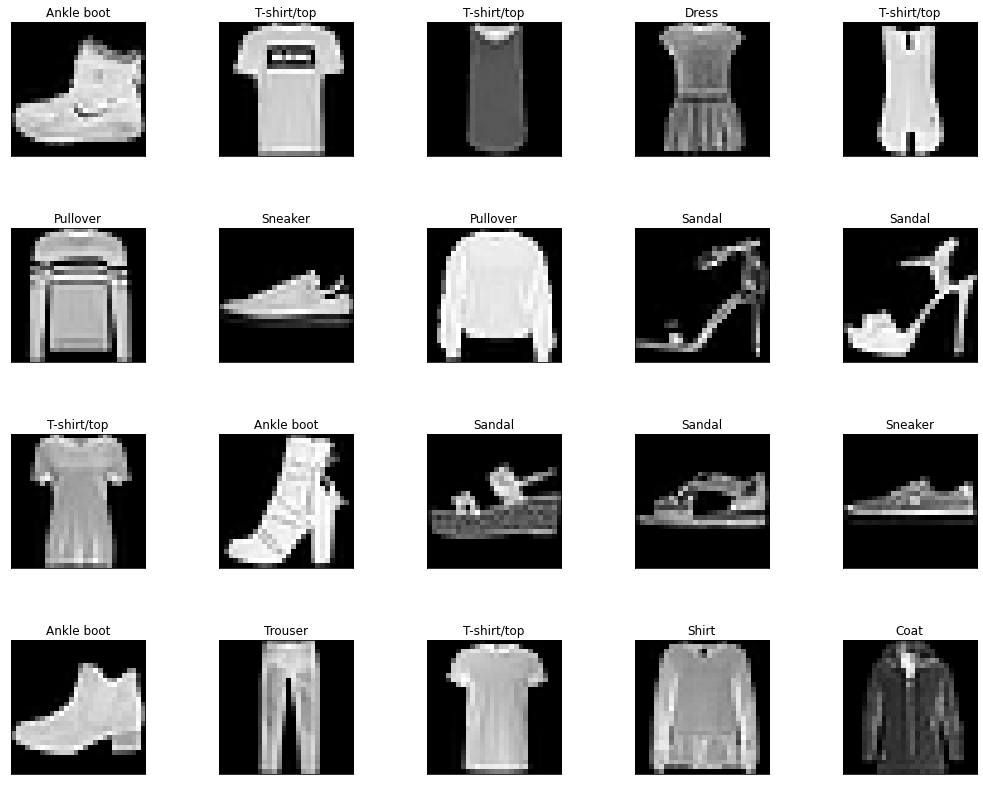

In [3]:
fig, ax = plt.subplots(4,5,figsize=(15,12))
fig.tight_layout(pad=4)
ax = ax.ravel()

for i in range(20):
    ax[i].imshow(train_data[i][0].view(28,28), cmap='gray')
    ax[i].set_title("{}".format(train_data.classes[train_data[i][1]]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### 2.2 Loadig the data using DataLoader
- Helps load data into a model for training and inference.

In [4]:
BATCH_SIZE = 32 

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

print("traininig set = {}, testing set = {} of size ={}".format(len(train_dataloader), len(test_dataloader), BATCH_SIZE)) 

traininig set = 1875, testing set = 313 of size =32


## 3. Building a model

### 3.1 Building a model
- Using nn.Linear building blocks

In [36]:
class FMNIST_model0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self,x):
        return self.layer_stack(x)

# With Non-linearity
class FMNIST_model1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
        
    def forward(self,x):
        return self.layer_stack(x)



### 3.2 Training and testing

In [134]:
INPUT_SHAPE = nn.Flatten()(next(iter(train_dataloader))[0][0]).shape[1]
HIDDEN_UNITS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FMNIST_model = FMNIST_model1
model = FMNIST_model(input_shape=INPUT_SHAPE, 
    hidden_units=HIDDEN_UNITS, # how many units in the hiden layer
    output_shape=len(train_data.classes) # one for every class
)
model.to(device) 

torch.manual_seed(42)
EPOCHS = 30
train_time_start_on_cpu = timer()

# Loss function and Optimizer 
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
losses = {'train_loss':[],
          'train_acc':[],
          'test_loss':[],
          'test_acc':[]}
for epoch in tqdm(range(EPOCHS)):
    
    print(f"Epoch: {epoch}\n---------")
    ## TRAINING
    train_results = DNN_utils.train_model(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    losses['train_loss'].append(train_results['model_loss'])
    losses['train_acc'].append(train_results['model_acc'])
    
    ## Print out what's happening
    print(f"\n Train loss: {train_results['model_loss']:.5f} | Train acc: {train_results['model_acc']:.2f}%\n")
    
    ## TESTING
    test_results = DNN_utils.test_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn)
    losses['test_loss'].append(test_results['model_loss'])
    losses['test_acc'].append(test_results['model_acc'])
    
    ## Print out what's happening
    print(f"Test loss: {test_results['model_loss']:.5f} | Test acc: {test_results['model_acc']:.2f}%\n")


train_time_end_on_cpu = timer()
total_train_time_model_0 = DNN_utils.print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------

 Train loss: 0.84555 | Train acc: 68.73%

Test loss: 0.53161 | Test acc: 81.18%

Epoch: 1
---------

 Train loss: 0.46486 | Train acc: 83.33%

Test loss: 0.50301 | Test acc: 82.66%

Epoch: 2
---------

 Train loss: 0.43381 | Train acc: 84.51%

Test loss: 0.46401 | Test acc: 83.98%

Epoch: 3
---------

 Train loss: 0.41913 | Train acc: 85.03%

Test loss: 0.47329 | Test acc: 83.24%

Epoch: 4
---------

 Train loss: 0.40762 | Train acc: 85.33%

Test loss: 0.43816 | Test acc: 84.42%

Epoch: 5
---------

 Train loss: 0.39887 | Train acc: 85.73%

Test loss: 0.45985 | Test acc: 83.69%

Epoch: 6
---------

 Train loss: 0.39411 | Train acc: 85.93%

Test loss: 0.43359 | Test acc: 84.80%

Epoch: 7
---------

 Train loss: 0.38833 | Train acc: 86.06%

Test loss: 0.46027 | Test acc: 83.43%

Epoch: 8
---------

 Train loss: 0.38475 | Train acc: 86.18%

Test loss: 0.41906 | Test acc: 85.07%

Epoch: 9
---------

 Train loss: 0.37938 | Train acc: 86.47%

Test loss: 0.43102 | Test acc

### 3.3 Visualizing the model performance

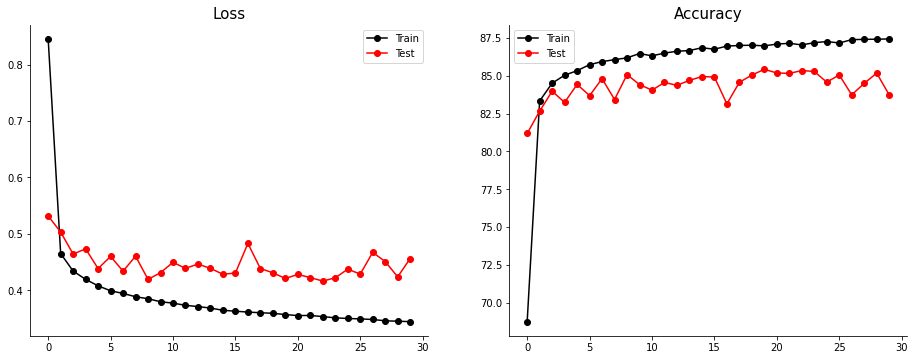

In [135]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=5)

ax[0].plot(losses['train_loss'], '-o', color='k', label='Train')
ax[0].plot(losses['test_loss'], '-o', color='r', label='Test')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Loss', fontsize=15)
ax[0].legend()


ax[1].plot(losses['train_acc'], '-o', color='k', label='Train')
ax[1].plot(losses['test_acc'], '-o', color='r', label='Test')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Accuracy', fontsize=15)
ax[1].legend()

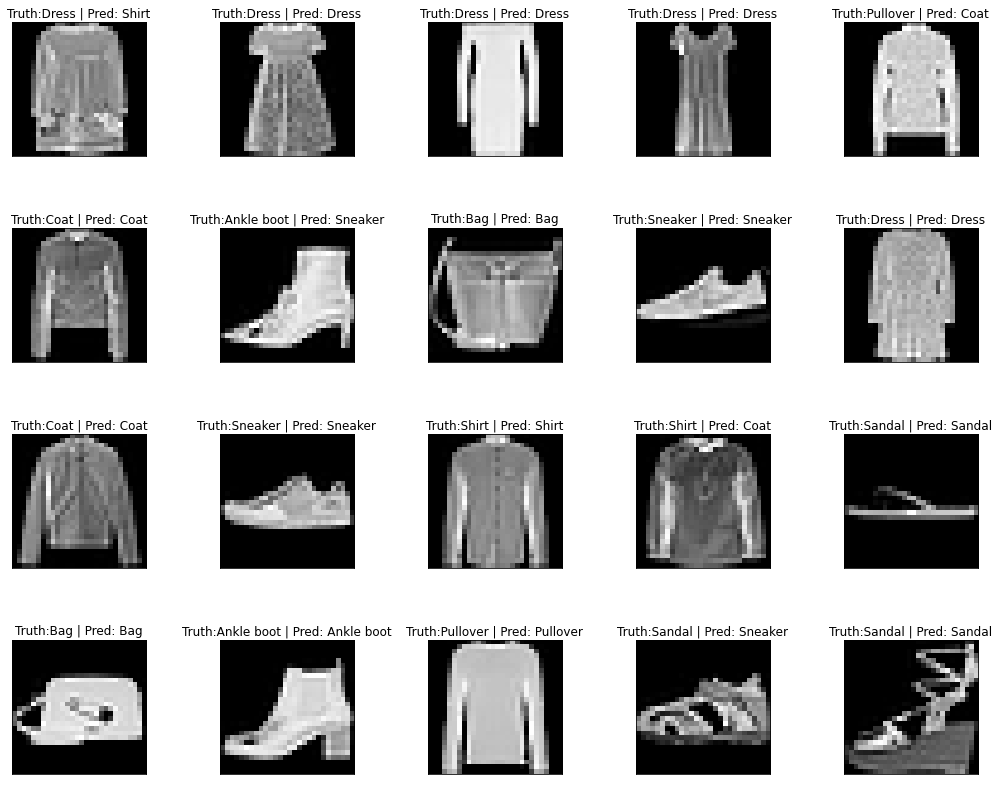

In [137]:
# Plotting the prediction
fig, ax = plt.subplots(4,5,figsize=(15,12))
fig.tight_layout(pad=4)
ax = ax.ravel()

input_data, true_label = next(iter(train_dataloader))
for i in range(20):
    pred_label = get_model_prediction(model, input_data[i,:,:,:])
    ax[i].imshow(torch.squeeze(input_data[i]), cmap='gray')
    ax[i].set_title("Truth:{} | Pred: {}".format(train_data.classes[true_label[i]], train_data.classes[pred_label]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [ ]:
# Plot confusion matrix

## 4 Building a CNN

### 4.1 Model definition 

In [138]:
class CNN_model(nn.Module):
    #. Mini VGG
    
    def  __init__(self, input_shape:int, output_shape:int, hidden_units:int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape))
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x)
        

## 4.2 Training

In [139]:
INPUT_SHAPE = 1 #nn.Flatten()(next(iter(train_dataloader))[0][0]).shape[1]
HIDDEN_UNITS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = CNN_model(input_shape=INPUT_SHAPE, 
                  hidden_units=HIDDEN_UNITS, # how many units in the hiden layer
                  output_shape=len(train_data.classes) # one for every class
                 ).to(device)

torch.manual_seed(43)
EPOCHS = 30
train_time_start_on_cpu = timer()

# Loss function and Optimizer 
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)
losses = {'train_loss':[],
          'train_acc':[],
          'test_loss':[],
          'test_acc':[]}
for epoch in tqdm(range(EPOCHS)):
    
    print(f"Epoch: {epoch}\n---------")
    ## TRAINING
    train_results = DNN_utils.train_model(model=model1, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    losses['train_loss'].append(train_results['model_loss'])
    losses['train_acc'].append(train_results['model_acc'])
    
    ## Print out what's happening
    print(f"\n Train loss: {train_results['model_loss']:.5f} | Train acc: {train_results['model_acc']:.2f}%\n")
    
    ## TESTING
    test_results = DNN_utils.test_model(model=model1, data_loader=test_dataloader, loss_fn=loss_fn)
    losses['test_loss'].append(test_results['model_loss'])
    losses['test_acc'].append(test_results['model_acc'])
    
    ## Print out what's happening
    print(f"Test loss: {test_results['model_loss']:.5f} | Test acc: {test_results['model_acc']:.2f}%\n")


train_time_end_on_cpu = timer()
total_train_time_model_0 = DNN_utils.print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------

 Train loss: 0.61827 | Train acc: 77.43%

Test loss: 0.42389 | Test acc: 84.59%

Epoch: 1
---------

 Train loss: 0.35660 | Train acc: 87.15%

Test loss: 0.35110 | Test acc: 87.17%

Epoch: 2
---------

 Train loss: 0.31665 | Train acc: 88.57%

Test loss: 0.34695 | Test acc: 87.38%

Epoch: 3
---------

 Train loss: 0.29703 | Train acc: 89.20%

Test loss: 0.30280 | Test acc: 89.33%

Epoch: 4
---------

 Train loss: 0.28346 | Train acc: 89.64%

Test loss: 0.30232 | Test acc: 89.06%

Epoch: 5
---------

 Train loss: 0.27336 | Train acc: 90.05%

Test loss: 0.29542 | Test acc: 89.43%

Epoch: 6
---------

 Train loss: 0.26558 | Train acc: 90.34%

Test loss: 0.30505 | Test acc: 89.11%

Epoch: 7
---------

 Train loss: 0.25709 | Train acc: 90.76%

Test loss: 0.29268 | Test acc: 89.51%

Epoch: 8
---------

 Train loss: 0.25350 | Train acc: 90.77%

Test loss: 0.28089 | Test acc: 89.89%

Epoch: 9
---------

 Train loss: 0.24829 | Train acc: 90.94%

Test loss: 0.28036 | Test acc

### 4.3 Visualizing the model performance

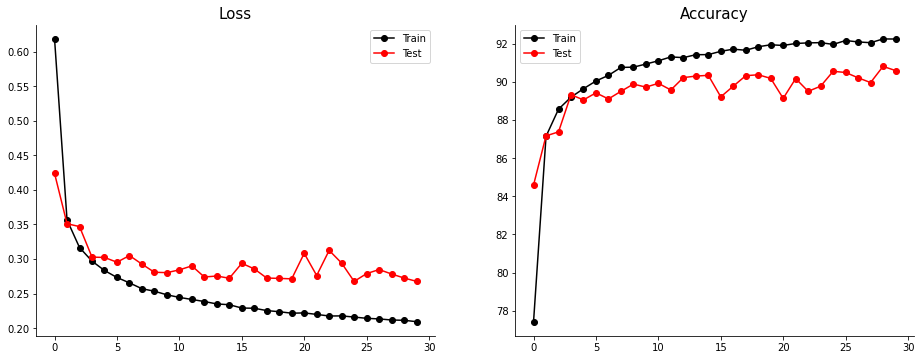

In [141]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=5)

ax[0].plot(losses['train_loss'], '-o', color='k', label='Train')
ax[0].plot(losses['test_loss'], '-o', color='r', label='Test')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Loss', fontsize=15)
ax[0].legend()


ax[1].plot(losses['train_acc'], '-o', color='k', label='Train')
ax[1].plot(losses['test_acc'], '-o', color='r', label='Test')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Accuracy', fontsize=15)
ax[1].legend()

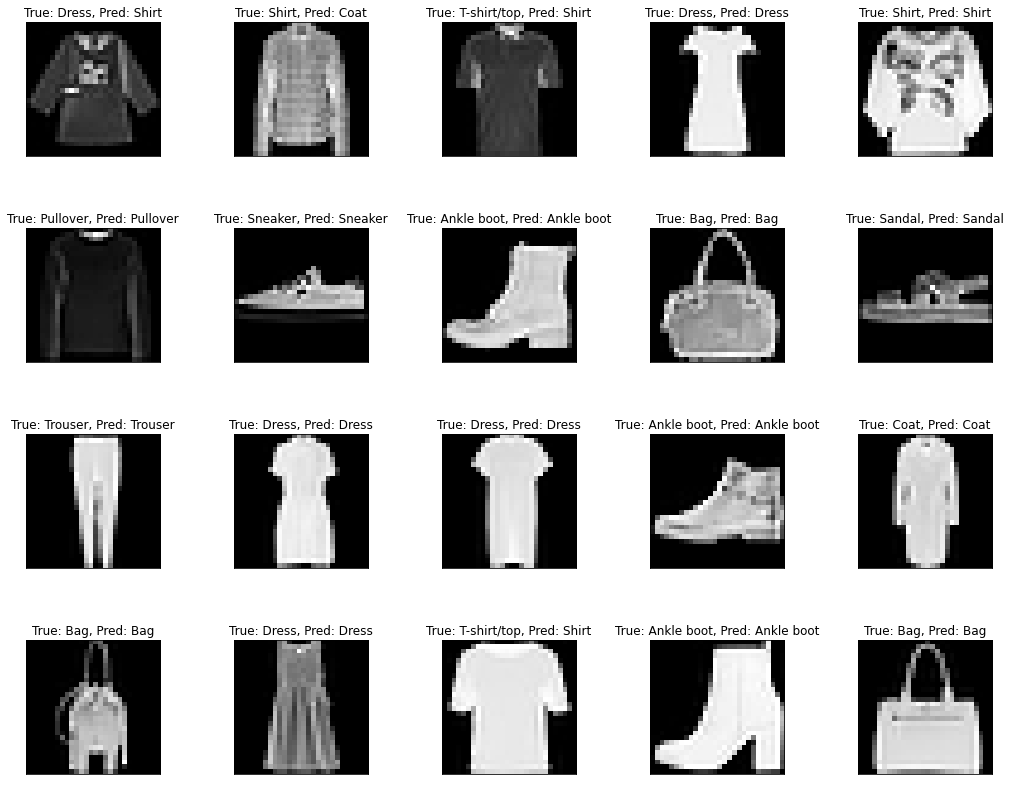

In [145]:
# Plotting the prediction
fig, ax = plt.subplots(4,5,figsize=(15,12))
fig.tight_layout(pad=4)
ax = ax.ravel()

input_data, true_labels = next(iter(train_dataloader))
for i in range(20):
    pred_label = get_model_prediction(model, input_data[i])
    ax[i].imshow(torch.squeeze(input_data[i]), cmap='gray')
    ax[i].set_title("True: {}, Pred: {}".format(train_data.classes[true_labels[i]], train_data.classes[pred_label]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [112]:
input_data.shape

torch.Size([32, 1, 28, 28])